In [29]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#load data from memory
data=pd.read_pickle('/scratch/lnw8px/GAN/data.pkl')

In [2]:
'''
normalize data
based on max and min values found on the dataprep section
'''

'\nnormalize data\nbased on max and min values found on the dataprep section\n'

In [30]:
def get_norm_data(array,val):
    return list(np.array(array)/val)

data['x_norm']=data['x'].apply(get_norm_data,args=[40])
data['y_norm']=data['y'].apply(get_norm_data,args=[80])
data['z_norm']=data['z'].apply(get_norm_data,args=[80])

In [31]:
'''
create onehot labels
'''

'\ncreate onehot labels\n'

In [32]:
num_classes=20
def to_onehot(num):
    onehot = np.zeros(num_classes,dtype=int)
    onehot[num-1] = 1
    return onehot

data['label']=data['gesture'].apply(to_onehot)

In [33]:
'''
crop data
'''

'\ncrop data\n'

In [34]:
def crop_array(array):
    #crop_len/10 is the length in seconds
    crop_len=30
    #pad array if its shorter than crop_len
    if(len(array)<crop_len):
        a=np.pad(array,pad_width=[0,(crop_len-len(array))],mode='edge')
    else:
        max_start=len(array)-crop_len
        start=randint(0,max_start)
        a=array[start:start+crop_len]
    return a 

crop_x=data['x_norm'].apply(crop_array)
crop_y=data['y_norm'].apply(crop_array)
crop_z=data['z_norm'].apply(crop_array)

data['crop_x']=crop_x
data['crop_y']=crop_y
data['crop_z']=crop_z

In [35]:
'''
select only the required columns
'''

'\nselect only the required columns\n'

In [36]:
data=data.drop(columns=['repitition','x','y','z','x_norm','y_norm','z_norm'])
data.head()

,user,gesture,crop_x,crop_y,crop_z,label
0,U07,16,"[0.214520475, 0.214520475, 0.22218192499999997...","[0.0497994, 0.0478840375, 0.044053312500000004...","[0.040222587500000004, 0.040222587500000004, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,U07,16,"[0.22984334999999997, 0.226012625, 0.226012625...","[0.01723825, 0.015322887499999998, 0.015322887...","[0.0478840375, 0.0497994, 0.0727837375, 0.1589...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,U07,16,"[0.20685905, 0.2030283, 0.226012625, 0.2758120...","[0.055545475, 0.053630124999999994, 0.06512228...","[0.0344765, 0.028730424999999997, 0.0689530125...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,U07,16,"[0.2030283, 0.21068975, 0.19153615, 0.24516624...","[0.055545475, 0.0517147625, 0.070868375, 0.099...","[0.0363918625, 0.038307225, 0.0689530125, 0.11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,U07,16,"[0.226012625, 0.2336741, 0.2030283, 0.2834735,...","[0.003830725, 0.0019153625, -0.0248997, -0.007...","[0.0517147625, 0.055545475, 0.0823605375, 0.16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
def get_max(array):
    return np.max(array)
def get_min(array):
    return np.min(array)
print(np.max(data['crop_x'].apply(get_max).values),np.min(data['crop_x'].apply(get_min).values))
print(np.max(data['crop_y'].apply(get_max).values),np.min(data['crop_y'].apply(get_min).values))
print(np.max(data['crop_z'].apply(get_max).values),np.min(data['crop_z'].apply(get_min).values))

0.8312668750000001 -0.9998186
0.9768342999999999 -0.4558559875
0.9768342999999999 -0.8121131874999999


In [38]:
'''
seperate train and test data.
one user is test. All others is train
'''

'\nseperate train and test data.\none user is test. All others is train\n'

In [39]:
users=data['user'].unique()
test_user=users[0]
train_users=users[users!=test_user]

train_data=data[data['user'].isin(train_users)]
test_data=data[data['user']==test_user]

In [40]:
train_data.head()

,user,gesture,crop_x,crop_y,crop_z,label
400,U03,11,"[0.0, 0.0, 0.068953, 0.0842759, 0.0651223, 0.0...","[0.0057460875, 0.0057460875, 0.0497994, 0.0900...","[0.12258312499999999, 0.12641385, 0.1225831249...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
401,U03,11,"[0.003830725, 0.00766145, 0.02681505, 0.076614...","[0.01723825, 0.01723825, 0.026815062499999997,...","[0.1244984875, 0.1244984875, 0.12641385, 0.134...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
402,U03,11,"[0.030645774999999997, 0.030645774999999997, 0...","[-0.0057460875, -0.0057460875, 0.045968675, 0....","[0.1283292125, 0.1244984875, 0.122583124999999...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
403,U03,11,"[0.00766145, 0.02681505, 0.061291575, 0.076614...","[0.0095768125, 0.0057460875, 0.044053312500000...","[0.1206677625, 0.1283292125, 0.118752412499999...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
404,U03,11,"[0.022984325, 0.0497994, 0.0651223, 0.0842759,...","[0.00766145, 0.0095768125, 0.05363012499999999...","[0.1244984875, 0.1244984875, 0.1130063125, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [41]:
def get_batch(data,batch_size):
    feature_list=[]
    label_list=[]
    batch=data.sample(n=batch_size)
    for i in range(len(batch)):
        features=[]
        features.append(batch.iloc[i]['crop_x'])
        features.append(batch.iloc[i]['crop_y'])
        features.append(batch.iloc[i]['crop_z'])
        features=np.array(features)
        feature_list.append(features)
        label_list.append(batch.iloc[i]['gesture']-1)
    features=np.array(feature_list)
    features=torch.from_numpy(features)
    features=features.to(device)
    features=features.float()
    
    labels=np.array(label_list)
    labels=torch.from_numpy(labels)
    labels=labels.to(device)
    labels=labels.long()
    return features,labels

In [42]:
features,labels=get_batch(data=train_data,batch_size=10)

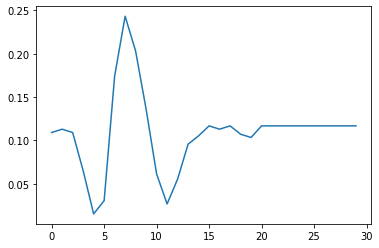

In [43]:
plt.plot(features.detach().cpu().numpy()[0][2])

In [44]:
def get_models(hidden1,hidden2):
    class GeneratorModel(nn.Module):
        def __init__(self):
            super(GeneratorModel, self).__init__()
            input_dim = 100 + 20
            output_dim = 30*3
            self.label_embedding = nn.Embedding(20, 20)

            self.hidden_layer1 = nn.Sequential(
                nn.Linear(input_dim, hidden1),
                nn.LeakyReLU(0.2)
            )

            self.hidden_layer2 = nn.Sequential(
                nn.Linear(hidden1, hidden2),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                nn.Linear(hidden2, output_dim),
                nn.Tanh()
            )

        def forward(self, x, labels):
            c = self.label_embedding(labels)
            x = torch.cat([x,c], 1)
            output = self.hidden_layer1(x)
            output = self.hidden_layer2(output)
            output = self.hidden_layer3(output)
            output = output.view(-1,3,30)
            return output.to(device)

    class DiscriminatorModel(nn.Module):
        def __init__(self):
            super(DiscriminatorModel, self).__init__()
            input_dim = 30*3 + 20
            output_dim = 1
            self.label_embedding = nn.Embedding(20, 20)

            self.hidden_layer1 = nn.Sequential(
                nn.Linear(input_dim, hidden1),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )
            
            self.hidden_layer2 = nn.Sequential(
                nn.Linear(hidden1, hidden2),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
            )

            self.hidden_layer3 = nn.Sequential(
                nn.Linear(hidden2, output_dim),
                nn.Sigmoid()
            )

        def forward(self, x, labels):
            c = self.label_embedding(labels)
            x = torch.cat([x, c], 1)
            output = self.hidden_layer1(x)
            output = self.hidden_layer2(output)
            output = self.hidden_layer3(output)
            return output.to(device)

    discriminator = DiscriminatorModel()
    generator = GeneratorModel()
    discriminator.to(device)
    generator.to(device)
    
    return generator,discriminator

In [27]:
generator

GeneratorModel(
  (label_embedding): Embedding(20, 20)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=120, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=64, out_features=90, bias=True)
    (1): Tanh()
  )
)

In [28]:
discriminator

DiscriminatorModel(
  (label_embedding): Embedding(20, 20)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [18]:
'''
get cross entropy betweeen the training distribution and the
generated data distribution
cross entropy increases when the two data distributions are more alike
'''

'\nget cross entropy betweeen the training distribution and the\ngenerated data distribution\ncross entropy increases when the two data distributions are more alike\n'

In [19]:
bin_edges=np.array(range(-10,11,1))/10
def get_prob(array):
    freq,ranges=np.histogram(array,bins=bin_edges)
    freq+=1
    prob=freq/np.sum(freq)
    return prob
def get_crossEntropy(p,q):
    p_probs=np.apply_along_axis(get_prob,axis=0,arr=p)
    q_probs=np.apply_along_axis(get_prob,axis=0,arr=q)
    mul=(p_probs*np.log2(q_probs))
    return -1*np.sum(mul)

def concat(row):
    ar1,ar2,ar3=row['crop_x'],row['crop_y'],row['crop_z']
    return np.concatenate([ar1,ar2,ar3])

def get_negative_coross_entropy_generator(train_data,generator):
    #get array from training data
    data=train_data.apply(concat,axis=1)
    p=np.array([item for item in data])
    
    #generate data with the generator
    noise = torch.randn(len(train_data),100).to(device)
    fake_labels = torch.randint(0, 20, (len(train_data),)).to(device)
    generated=generator(noise,fake_labels)
    generated=generated.detach().cpu().numpy()
    generated=generated.reshape(2851,-1)

    #get the corr entropy form these distributions
    ce=get_crossEntropy(p,generated)
    return ce

#entropy of the train distribution 
data=train_data.apply(concat,axis=1)
p=np.array([item for item in data])
ce=get_crossEntropy(p,p)
print(ce)

155.9490096034991


In [ ]:
out_file='/home/lnw8px/models/GAN/results.txt'
n_epochs = 200
batch_size = 16
num_batches = len(train_data)
lr=0.0002
discount=0.9
print("Number of batches: ",num_batches)
current_CE=1000


generator,discriminator=get_models(hidden1=256,hidden2=64)
generator.train()
discriminator.train()
loss = nn.BCELoss()

for epoch_idx in range(n_epochs):
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
    print('lr='+str(lr))

    f = open(out_file, "a")
    f.write('lr = ' + str(lr)+'\n')
    f.close()
    
    G_loss = []
    D_loss = []
    
    for batch_idx  in range(num_batches):

        features,labels=get_batch(data=train_data,batch_size=batch_size)

        noise = torch.randn(batch_size,100).to(device)
        fake_labels = torch.randint(0, 20, (batch_size,)).to(device)
        generated_data = generator(noise, fake_labels).view(batch_size,-1)

        # Discriminator
        true_data = features.view(batch_size, -1).to(device) # batch_size X 784
        digit_labels = labels.to(device) # batch_size
        true_labels = torch.ones(batch_size).to(device)

        discriminator_optimizer.zero_grad()

        discriminator_output_for_true_data = discriminator(true_data, digit_labels).view(batch_size)

        true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

        discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_labels).view(batch_size)

        generator_discriminator_loss = loss(
            discriminator_output_for_generated_data, torch.zeros(batch_size).to(device)
        )
        discriminator_loss = (
            true_discriminator_loss + generator_discriminator_loss
        ) / 2

        discriminator_loss.backward()
        discriminator_optimizer.step()

        D_loss.append(discriminator_loss.data.item())

        # Generator

        generator_optimizer.zero_grad()
        # It's a choice to generate the data again
        generated_data = generator(noise, fake_labels).view(batch_size,-1)

        discriminator_output_on_generated_data = discriminator(generated_data, fake_labels).view(batch_size)

        generator_loss = loss(discriminator_output_on_generated_data, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        G_loss.append(generator_loss.data.item())


    cross_entropy=get_negative_coross_entropy_generator(train_data,generator)

    f = open(out_file, "a")
    f.write('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
    f.write('\n')
    f.write('cross entropy='+str(cross_entropy))
    f.write('\n')
    f.close()
    
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
    print('cross entropy='+str(cross_entropy))
    lr=lr*discount
    
    #save the model if it have the lowest cross entropy yet
    if(cross_entropy<current_CE):
        torch.save(generator.state_dict(),'/scratch/lnw8px/GAN/models/generator.pt')
        current_CE=cross_entropy
        print('saved model')

In [ ]:
'''
get the cross entropy between generated and real data
'''

In [45]:
generator,discriminator=get_models(hidden1=256,hidden2=64)
generator.load_state_dict(torch.load('/scratch/lnw8px/GAN/models/generator.pt'))

<All keys matched successfully>

In [25]:
cross_entropy=get_negative_coross_entropy_generator(train_data,generator)
cross_entropy

159.01201878698572

In [ ]:
'''
Generate some samples and plot them
'''

In [48]:
#generate 10 samples
batch_size=10
noise = torch.randn(batch_size,100).to(device)
fake_labels = torch.randint(0, 20, (batch_size,)).to(device)
generated=generator(noise,fake_labels)
generated=generated.detach().cpu().numpy()

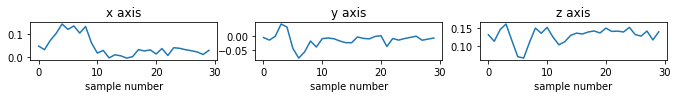

In [60]:
plt.subplot(5,3,1)
plt.plot(generated[1][0])
plt.title('x axis')
plt.xlabel('sample number')

plt.subplot(5,3,2)
plt.plot(generated[1][1])
plt.title('y axis')
plt.xlabel('sample number')

plt.subplot(5,3,3)
plt.plot(generated[1][2])
plt.title('z axis')
plt.xlabel('sample number')

plt.subplots_adjust(left=None, bottom=None, right=1.6, top=None, wspace=None, hspace=None)

plt.show()

In [ ]:
'''
Select the best hidden dimention sizes
'''

In [197]:
out_file='/home/lnw8px/models/GAN/results1.txt'
n_epochs = 20
batch_size = 32
num_batches = len(train_data)
hidden_dims=[16,32,64,128,256,512]
print("Number of batches: ",num_batches)

for hidden1 in hidden_dims:
    for hidden2 in hidden_dims:
        
        generator,discriminator=get_models(hidden1=32,hidden2=64)
        generator.train()
        discriminator.train()

        discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
        generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

        loss = nn.BCELoss()
        
        f = open(out_file, "a")
        f.write(str(hidden1)+','+str(hidden2)+'\n')
        f.close()
        
        for epoch_idx in range(n_epochs):
            G_loss = []
            D_loss = []
            for batch_idx  in range(num_batches):

                features,labels=get_batch(data=train_data,batch_size=batch_size)

                noise = torch.randn(batch_size,100).to(device)
                fake_labels = torch.randint(0, 20, (batch_size,)).to(device)
                generated_data = generator(noise, fake_labels).view(batch_size,-1)

                # Discriminator
                true_data = features.view(batch_size, -1).to(device) # batch_size X 784
                digit_labels = labels.to(device) # batch_size
                true_labels = torch.ones(batch_size).to(device)

                discriminator_optimizer.zero_grad()

                discriminator_output_for_true_data = discriminator(true_data, digit_labels).view(batch_size)

                true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

                discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_labels).view(batch_size)

                generator_discriminator_loss = loss(
                    discriminator_output_for_generated_data, torch.zeros(batch_size).to(device)
                )
                discriminator_loss = (
                    true_discriminator_loss + generator_discriminator_loss
                ) / 2

                discriminator_loss.backward()
                discriminator_optimizer.step()

                D_loss.append(discriminator_loss.data.item())

                # Generator

                generator_optimizer.zero_grad()
                # It's a choice to generate the data again
                generated_data = generator(noise, fake_labels).view(batch_size,-1)

                discriminator_output_on_generated_data = discriminator(generated_data, fake_labels).view(batch_size)

                generator_loss = loss(discriminator_output_on_generated_data, true_labels)
                generator_loss.backward()
                generator_optimizer.step()

                G_loss.append(generator_loss.data.item())
                
            
            f = open(out_file, "a")
            f.write('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                    (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
            f.write('\n')
            f.write('cross entropy='+str(get_negative_coross_entropy_generator(train_data,generator)))
            f.write('\n')
            f.close()
            print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                    (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
            print('cross entropy='+str(get_negative_coross_entropy_generator(train_data,generator)))

Number of batches:  2851
[0/20]: loss_d: 0.688, loss_g: 0.703
cross entropy=208.0268099997408
[1/20]: loss_d: 0.693, loss_g: 0.693
cross entropy=181.5684180072442



KeyboardInterrupt

